In [1]:
!pip install squarify

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import squarify
from matplotlib import style
style.use('ggplot')

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
%cd /content/gdrive/My Drive/Contelligenz Data Science/Datasets

/content/gdrive/My Drive/Contelligenz Data Science/Datasets


In [5]:
!ls

'Bollywood Movies Dataset.xlsx'   user_item_interactions_implicit_binary_v1.csv
 content_catalog_v1.csv		  user_profile_with_recommendations_v1.csv


In [6]:
df = pd.read_csv('user_profile_with_recommendations_v1.csv')

In [7]:
df.head()

,total_titles_viewed,startDate,latestDate,activeDuration,sessionsCount,sessionsperDay,total_view_minutes,avg_video_completion_rate,subscription_type,userAge,Recency,userType,userStatus,userid,user_title_recommendations,viewing_history
0,1,2021-05-02,2021-05-02,1,1,1.000000,8.5,0.056242,Paid,24,24,Existing,Inactive,0,[200 30 233 212 302 199 266 198 37 252 77 1...,[43]
1,2,2021-05-08,2021-05-11,4,4,1.000000,142.5,0.989698,Paid,18,15,Existing,Active,1,[ 61 237 286 306 198 37 250 84 46 70 305 ...,"[158, 190]"
2,13,2021-05-02,2021-05-23,22,31,1.409091,744.0,5.820258,Paid,24,3,Existing,Active,3,[198 305 199 193 210 306 200 70 180 43 30 2...,"[28, 37, 41, 72, 104, 163, 190, 230, 243, 261,..."
3,5,2021-05-10,2021-05-21,12,23,1.916667,173.5,6.906419,Paid,16,5,Existing,Active,4,[198 193 30 286 199 306 305 43 61 200 70 2...,"[75, 178, 210, 237, 266]"
4,8,2021-05-02,2021-05-24,23,21,0.913043,451.0,6.905010,Paid,24,2,Existing,Active,5,[198 305 286 193 30 306 43 277 180 264 77 2...,"[40, 70, 104, 155, 204, 233, 250, 266]"


In [8]:
df['startDate'] = pd.to_datetime(df['startDate'])
df['latestDate'] = pd.to_datetime(df['latestDate'])

In [9]:
snapshot_date = df['latestDate'].max() + timedelta(days = 1)
snapshot_date

Timestamp('2021-05-26 00:00:00')

In [10]:
data_process = df.groupby('userid').agg({
    'latestDate': lambda x: (snapshot_date - x.max()).days,
    'sessionsCount': 'sum',
    'total_view_minutes': 'sum'
})

In [11]:
data_process.rename(columns = {'latestDate': 'Recency',
                               'sessionsCount': 'Frequency',
                               'total_view_minutes': 'MonetaryValue'}, inplace = True)

In [12]:
data_process.head()

,Recency,Frequency,MonetaryValue
userid,,,
0,24,1,8.5
1,15,4,142.5
3,3,31,744.0
4,5,23,173.5
5,2,21,451.0


In [13]:
data_process.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39005 entries, 0 to 51543
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Recency        39005 non-null  int64  
 1   Frequency      39005 non-null  int64  
 2   MonetaryValue  39005 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 1.2 MB


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

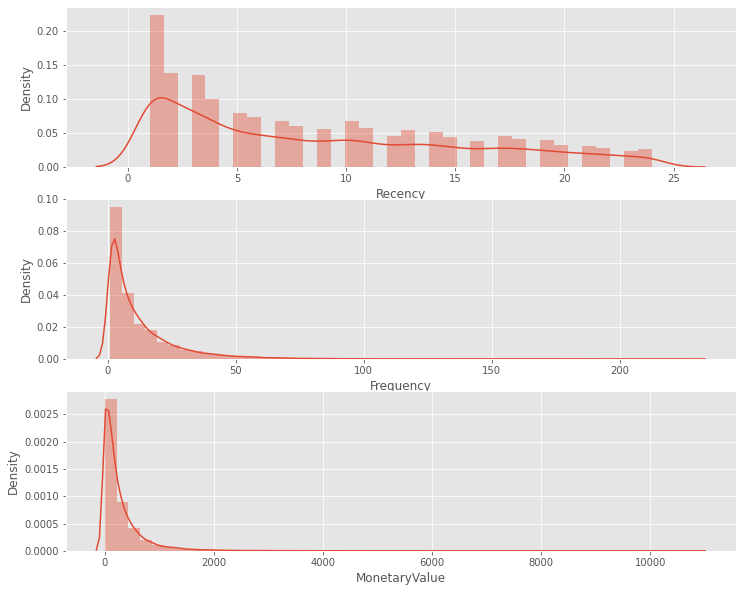

In [14]:
plt.figure(figsize = (12, 10))

plt.subplot(3, 1, 1)
sns.distplot(data_process['Recency'])

plt.subplot(3, 1, 2)
sns.distplot(data_process['Frequency'])

plt.subplot(3, 1, 3)
sns.distplot(data_process['MonetaryValue'])

plt.show()

In [15]:
r_labels = range(4, 0, -1)
f_labels = range(1, 5)

r_groups = pd.qcut(data_process['Recency'],#

data_process = data_process.assign(R = r_groups.values, F = f_groups.values)

data_process.head()

,Recency,Frequency,MonetaryValue,R,F
userid,,,,,
0,24,1,8.5,1,1
1,15,4,142.5,1,2
3,3,31,744.0,4,4
4,5,23,173.5,3,4
5,2,21,451.0,4,4


In [16]:
m_labels = range(1, 5)
m_groups = pd.qcut(data_process['MonetaryValue'], q = 4, labels = m_labels)

data_process = data_process.assign(M = m_groups.values)
data_process.head()

,Recency,Frequency,MonetaryValue,R,F,M
userid,,,,,,
0,24,1,8.5,1,1,1
1,15,4,142.5,1,2,2
3,3,31,744.0,4,4,4
4,5,23,173.5,3,4,3
5,2,21,451.0,4,4,4


In [19]:
def join_rfm(x):
  return str(x['R']) + str(x['F']) + str(x['M'])

data_process['RFM_Segment_Concat'] = data_process.apply(join_rfm, axis = 1)
rfm = data_process
rfm.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment_Concat
userid,,,,,,,
0,24,1,8.5,1,1,1,111
1,15,4,142.5,1,2,2,122
3,3,31,744.0,4,4,4,444
4,5,23,173.5,3,4,3,343
5,2,21,451.0,4,4,4,444


In [20]:
rfm_count_unique = rfm.groupby('RFM_Segment_Concat')['RFM_Segment_Concat'].nunique()
print(rfm_count_unique.sum())

64


In [21]:
rfm['RFM_score'] = rfm[['R', 'F', 'M']].sum(axis = 1)
print(rfm['RFM_score'].head())

userid
0     3
1     5
3    12
4    10
5    12
Name: RFM_score, dtype: int64


In [22]:
def rfm_level(x):
  if (x['RFM_score'] >= 9):
    return 'Can\'t loose them!!'
  elif ((x['RFM_score'] >= 8) and (x['RFM_score'] < 9)):
    return 'Champions'
  elif ((x['RFM_score'] >= 7) and (x['RFM_score'] < 8)):
    return 'Loyal'
  elif ((x['RFM_score'] >= 6) and (x['RFM_score'] < 7)):
    return 'Potential'
  elif ((x['RFM_score'] >= 5) and (x['RFM_score'] < 6)):
    return 'Promising'
  elif ((x['RFM_score'] >= 4) and (x['RFM_score'] < 5)):
    return 'Needs attention'
  else:
    return 'Require activation'

rfm['RFM_Level'] = rfm.apply(rfm_level, axis = 1)
rfm.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment_Concat,RFM_score,RFM_Level
userid,,,,,,,,,
0,24,1,8.5,1,1,1,111,3,Require activation
1,15,4,142.5,1,2,2,122,5,Promising
3,3,31,744.0,4,4,4,444,12,Can't loose them!!
4,5,23,173.5,3,4,3,343,10,Can't loose them!!
5,2,21,451.0,4,4,4,444,12,Can't loose them!!


In [64]:
##### Can't loose them #####
df_precious = rfm.loc[rfm['RFM_Level'] == 'Can\'t loose them!!']
df_precious.head()

#print(round(len(df_precious) / len(rfm) * 100, 2))

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment_Concat,RFM_score,RFM_Level
userid,,,,,,,,,
3,3,31,744.0,4,4,4,444,12,Can't loose them!!
4,5,23,173.5,3,4,3,343,10,Can't loose them!!
5,2,21,451.0,4,4,4,444,12,Can't loose them!!
7,1,35,1095.5,4,4,4,444,12,Can't loose them!!
11,1,42,494.5,4,4,4,444,12,Can't loose them!!


In [65]:
##### Champions ######
df_champions = rfm.loc[rfm['RFM_Level'] == 'Champions']
df_champions.head()

#round(len(df_champions) / len(rfm) * 100, 2)

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment_Concat,RFM_score,RFM_Level
userid,,,,,,,,,
8,6,6,316.5,3,2,3,323,8,Champions
26,4,4,155.0,3,2,3,323,8,Champions
55,12,53,38.5,2,4,2,242,8,Champions
67,13,9,238.0,2,3,3,233,8,Champions
105,6,12,117.5,3,3,2,332,8,Champions


In [66]:
##### Loyal ######
df_loyal = rfm.loc[rfm['RFM_Level'] == 'Loyal']
df_loyal.head()

#round(len(df_loyal) / len(rfm) * 100, 2)

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment_Concat,RFM_score,RFM_Level
userid,,,,,,,,,
38,6,7,128.5,3,2,2,322,7,Loyal
42,10,11,92.5,2,3,2,232,7,Loyal
45,8,7,182.5,2,2,3,223,7,Loyal
46,7,6,125.0,3,2,2,322,7,Loyal
51,8,4,349.0,2,2,3,223,7,Loyal


In [67]:
##### Potential ######
df_potential = rfm.loc[rfm['RFM_Level'] == 'Potential']
df_potential.head()

#round(len(df_potential) / len(rfm) * 100, 2)

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment_Concat,RFM_score,RFM_Level
userid,,,,,,,,,
28,1,2,1.5,4,1,1,411,6,Potential
31,8,6,65.5,2,2,2,222,6,Potential
40,2,1,5.5,4,1,1,411,6,Potential
41,11,6,42.0,2,2,2,222,6,Potential
64,9,4,117.0,2,2,2,222,6,Potential


In [68]:
##### Promising ######
df_promising = rfm.loc[rfm['RFM_Level'] == 'Promising']
df_promising.head()

#round(len(df_promising) / len(rfm) * 100, 2)

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment_Concat,RFM_score,RFM_Level
userid,,,,,,,,,
1,15,4,142.5,1,2,2,122,5,Promising
16,6,3,20.5,3,1,1,311,5,Promising
19,20,4,121.0,1,2,2,122,5,Promising
34,23,6,100.0,1,2,2,122,5,Promising
35,21,5,39.5,1,2,2,122,5,Promising


In [69]:
##### Need attention ######
df_attention = rfm.loc[rfm['RFM_Level'] == 'Needs attention']
df_attention.head()

#round(len(df_attention) / len(rfm) * 100, 2)

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment_Concat,RFM_score,RFM_Level
userid,,,,,,,,,
6,18,2,46.0,1,1,2,112,4,Needs attention
32,12,1,0.0,2,1,1,211,4,Needs attention
36,22,6,31.0,1,2,1,121,4,Needs attention
49,14,2,22.0,2,1,1,211,4,Needs attention
50,16,7,19.0,1,2,1,121,4,Needs attention


In [70]:
##### Require activation ######
df_activation = rfm.loc[rfm['RFM_Level'] == 'Require activation']
df_activation.head()

#round(len(df_activation) / len(rfm) * 100, 2)

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment_Concat,RFM_score,RFM_Level
userid,,,,,,,,,
0,24,1,8.5,1,1,1,111,3,Require activation
25,23,2,30.0,1,1,1,111,3,Require activation
27,24,1,0.5,1,1,1,111,3,Require activation
33,19,1,1.0,1,1,1,111,3,Require activation
37,22,1,0.0,1,1,1,111,3,Require activation


In [63]:
rfm_level_agg = rfm.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
}).round(1)

#rfm_level_agg['MonetaryValue']['count']
rfm_level_agg['MonetaryValue', 'percent'] = (rfm_level_agg['MonetaryValue']['count'] / len(rfm)) * 100

rfm_level_agg

Recency Frequency MonetaryValue                  
                      mean      mean          mean  count    percent
RFM_Level                                                           
Can't loose them!!     3.9      23.8         569.7  15512  39.769260
Champions              7.4       9.2         208.6   3944  10.111524
Loyal                  8.6       6.7         148.3   3910  10.024356
Needs attention       15.2       2.1          40.1   4174  10.701192
Potential              9.0       4.4          87.4   4199  10.765287
Promising             12.0       3.3          65.5   3687   9.452634
Require activation    19.6       1.5           7.4   3579   9.175747

In [ ]:
(15512 + 3944 + 3910)/len(rfm.Recency) * 100

59.90514036661967

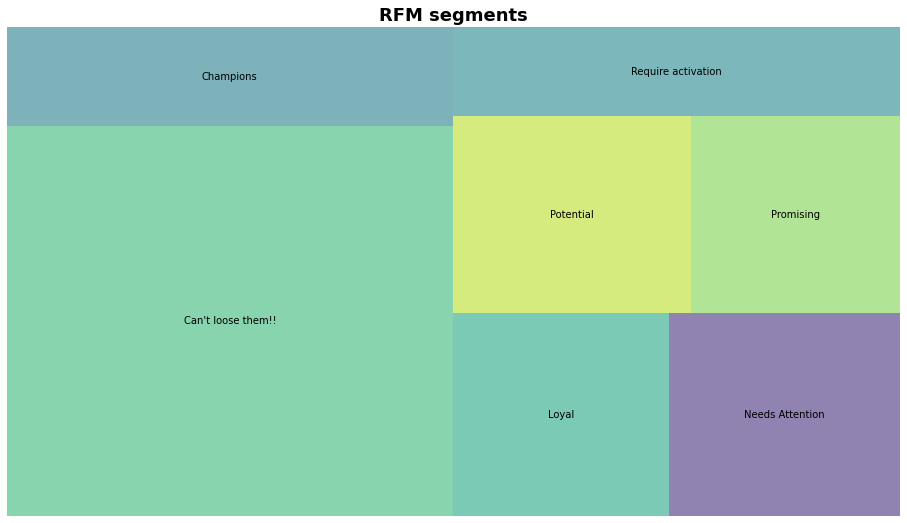

In [ ]:
rfm_level_agg.columns = rfm_level_agg.columns.droplevel()
rfm_level_agg.columns = ['RecencyMean', 'FrequencyMean', 'MonetaryMean', 'Count']

fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)

squarify.plot(sizes = rfm_level_agg['Count'],
              label = ['Can\'t loose them!!',
                       'Champions',
                       'Loyal',
                       'Needs Attention',
                       'Potential',
                       'Promising',
                       'Require activation'], alpha = 0.6)

plt.title('RFM segments', fontsize = 18, fontweight = 'bold')
plt.axis('off')
plt.show()

In [79]:
####### Best Customers i.e. 444

bestCustomers = rfm.loc[rfm['RFM_Segment_Concat'] == '444']
bestCustomers

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment_Concat,RFM_score,RFM_Level
userid,,,,,,,,,
3,3,31,744.0,4,4,4,444,12,Can't loose them!!
5,2,21,451.0,4,4,4,444,12,Can't loose them!!
7,1,35,1095.5,4,4,4,444,12,Can't loose them!!
11,1,42,494.5,4,4,4,444,12,Can't loose them!!
23,1,25,593.5,4,4,4,444,12,Can't loose them!!
...,...,...,...,...,...,...,...,...,...
51422,1,44,683.0,4,4,4,444,12,Can't loose them!!
51423,1,19,595.5,4,4,4,444,12,Can't loose them!!
51432,2,33,1236.5,4,4,4,444,12,Can't loose them!!


In [80]:
len(bestCustomers) / len(rfm) * 100

10.573003461094732

In [82]:
##### Loyal based on frequency i.e X4X
loyalCustomers = rfm.loc[rfm['F'] == 4]
loyalCustomers

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment_Concat,RFM_score,RFM_Level
userid,,,,,,,,,
3,3,31,744.0,4,4,4,444,12,Can't loose them!!
4,5,23,173.5,3,4,3,343,10,Can't loose them!!
5,2,21,451.0,4,4,4,444,12,Can't loose them!!
7,1,35,1095.5,4,4,4,444,12,Can't loose them!!
11,1,42,494.5,4,4,4,444,12,Can't loose them!!
...,...,...,...,...,...,...,...,...,...
51497,10,36,441.5,2,4,4,244,10,Can't loose them!!
51498,1,19,315.5,4,4,3,443,11,Can't loose them!!
51508,10,18,1466.5,2,4,4,244,10,Can't loose them!!


In [83]:
len(loyalCustomers) / len(rfm) * 100

24.24817331111396

In [84]:
######## Most Engaging Customers i.e XX4
mostEngagingCutomers = rfm.loc[rfm['M'] == 4]
mostEngagingCutomers

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment_Concat,RFM_score,RFM_Level
userid,,,,,,,,,
3,3,31,744.0,4,4,4,444,12,Can't loose them!!
5,2,21,451.0,4,4,4,444,12,Can't loose them!!
7,1,35,1095.5,4,4,4,444,12,Can't loose them!!
11,1,42,494.5,4,4,4,444,12,Can't loose them!!
12,10,31,420.0,2,4,4,244,10,Can't loose them!!
...,...,...,...,...,...,...,...,...,...
51455,5,8,1030.5,3,3,4,334,10,Can't loose them!!
51486,14,13,806.0,2,3,4,234,9,Can't loose them!!
51491,1,40,709.5,4,4,4,444,12,Can't loose them!!


In [85]:
len(mostEngagingCutomers) / len(rfm) * 100

24.976285091654916

In [86]:
len(df['userid'])

39005

In [87]:
len(df['userid'].unique())

39005